# 1. Basic settings

In [1]:
import time
import numpy as np
from CS231n.classifiers.fc_net import *
from CS231n.data_utils import get_CIFAR10_data
from CS231n.solver import Solver
from CS231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# Optional setting
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# 2. Data loading and Preprocessing

In [5]:
# Load the CIFAR10 data.
DIR_data = 'D:/CS231N_CNN/DataSet/cifar-10-batches-py/'

# the mean image has been sub-tracted
data = get_CIFAR10_data(DIR_data, num_training=49000, num_validation=1000)
# data is a dictionary:
# data = {
#        'X_train': X_train, 'y_train': y_train,
#        'X_val': X_val, 'y_val': y_val,
#        'X_test': X_test, 'y_test': y_test,
#    }

for k, v in data.items():
    print("The shape of %s is " %k,v.shape)

The shape of X_train is  (49000, 3, 32, 32)
The shape of y_train is  (49000,)
The shape of X_val is  (1000, 3, 32, 32)
The shape of y_val is  (1000,)
The shape of X_test is  (1000, 3, 32, 32)
The shape of y_test is  (1000,)


## 3.1. Sanity check 1

In [6]:
from CS231n.classifiers.cnn import FirstConvNet
model = FirstConvNet(use_batchnorm=True)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print( 'Initial loss (no regularization): ', loss)

model.reg = 1.0
loss, grads = model.loss(X, y)
print( 'Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.30236785889
Initial loss (with regularization):  2.41260663185


## 3.2. Sanity check 2 - Gradietn check

In [7]:
num_inputs = 2
input_dim = (3, 12, 12)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = FirstConvNet(input_dim=input_dim,
                     dtype=np.float64,
                     num_filters = [3],
                     hidden_dims = [3,3],use_batchnorm = True)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print( '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 2.622130e-06
W2 max relative error: 1.174956e-06
W3 max relative error: 8.877770e-08
W4 max relative error: 7.155612e-08
b1 max relative error: 1.734723e-10
b2 max relative error: 8.673617e-11
b3 max relative error: 0.000000e+00
b4 max relative error: 1.240865e-09
beta1 max relative error: 2.309687e-06
beta2 max relative error: 1.489740e-06
beta3 max relative error: 1.145001e-06
gamma1 max relative error: 1.756470e-06
gamma2 max relative error: 3.487141e-05
gamma3 max relative error: 7.370572e-06


## 3.3. Sanity check 3: Overfit a small dataset

In [8]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = FirstConvNet(weight_scale=5e-2,use_batchnorm = False)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='Adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration "1" / "40") loss: "4.050635"
(Epoch "0" / "20") train acc: "0.180000"; val_acc: "0.144000"
(Iteration "2" / "40") loss: "2.755930"
(Epoch "1" / "20") train acc: "0.330000"; val_acc: "0.173000"
(Iteration "3" / "40") loss: "2.396112"
(Iteration "4" / "40") loss: "2.643335"
(Epoch "2" / "20") train acc: "0.400000"; val_acc: "0.145000"
(Iteration "5" / "40") loss: "1.907696"
(Iteration "6" / "40") loss: "1.880950"
(Epoch "3" / "20") train acc: "0.390000"; val_acc: "0.168000"
(Iteration "7" / "40") loss: "1.922502"
(Iteration "8" / "40") loss: "1.534254"
(Epoch "4" / "20") train acc: "0.480000"; val_acc: "0.163000"
(Iteration "9" / "40") loss: "1.591058"
(Iteration "10" / "40") loss: "1.530045"
(Epoch "5" / "20") train acc: "0.600000"; val_acc: "0.171000"
(Iteration "11" / "40") loss: "1.549571"
(Iteration "12" / "40") loss: "1.262886"
(Epoch "6" / "20") train acc: "0.660000"; val_acc: "0.195000"
(Iteration "13" / "40") loss: "1.389375"
(Iteration "14" / "40") loss: "1.258442"
(

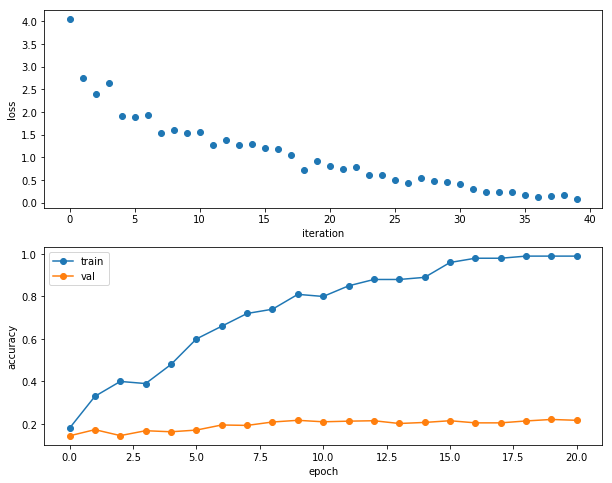

In [9]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## 4. Train a model

In [ ]:
model_1 = FirstConvNet(weight_scale=5e-2, reg=0.01,
                       filter_size = 3,
                       
                       use_batchnorm=True,
                       num_filters=[16, 32, 64],
                       hidden_dims=[500, 500])

solver_1 = Solver(model_1, data,
                num_epochs=5, batch_size=50,
                lr_decay = 0.95,
                update_rule='Adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=40)
solver_1.train()

In [ ]:
solver = solver_1
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## 5 Extral Experiments

In [ ]:
import json
class ModelExp(object):
    ''' Class to handle the different model run for the experiments '''
    def __init__(self,model):
        self.model = model
        self.versions = [f for f in os.listdir(model) if f[:2] == 'lr']
        
    def __str__(self):
        conf_file = os.path.join(self.model,'conf_init.json')
        with open(conf_file, 'r') as f:
            conf = json.load(f)
        for key,elt in conf.iteritems():
                print( str(key),' : ', str(elt))
        
    def get_best_val(self):
        d = self.get_checkpoints()
        return {key:f['best_val_acc'] for key,f in d.iteritems()}
    
    def get_best_model(self):
        d = self.get_checkpoints()
        return {key:[f['best_val_acc'],f['best_params'],f['model']] for key,f in d.iteritems()}
    
    
    def get_checkpoint_name(self,version):
        ''' Given a specific version of the model ,return the name of the last checkpoint '''
        
        path = os.path.join(self.model,version,'checkpoints')
        return 'check_'+str(max(map(int,[f.split('_')[-1] for f in os.listdir(path)])))

    def get_checkpoints_name(self):
        ''' Return a dict with the different version and their corresponding last checkpoints name '''
        
        return {key:self.get_checkpoint_name(os.path.join(self.model,key)) for key in self.versions}

    def get_checkpoint(self,version,name):
        ''' Given a version of the model and a checkpoint name, return the checkpoit itself'''
        
        return joblib.load(os.path.join(self.model,version,'checkpoints',name,name+'.pkl'))
    
    def get_last_checkpoint(self,version):
        ''' Given a version of the model, return the last checkpoint itselfk'''
        name = self.get_checkpoint_name(version)
        return joblib.load(os.path.join(self.model,version,'checkpoints',name,name+'.pkl'))        
        
    def get_checkpoints(self):
        ''' Return a dict with the different version and their corresponding last checkpoints '''
        
        d = self.get_checkpoints_name()
        return {version:self.get_checkpoint(version,name) for version,name in d.iteritems()}
    
    def inspect_last_checkpoint(self,version,ymax):
        check = self.get_last_checkpoint(version)
        fig = plt.figure(figsize=(15, 5))
        ax1 = plt.subplot(121)
        ax1.plot(check['loss_history'], label=version)
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('accuracy')
        ax1.set_title(version,fontsize = 24)
        ax1.legend(loc = 'upper right',fontsize = 24)
        ax1.set_ylim(0,ymax)
        ax2 = plt.subplot(122)
        ax2.plot(check['train_acc_history'],label = version+'-train')
        ax2.plot(check['val_acc_history'],label = version+'-val')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('accuracy')
        ax2.legend(loc = 'lower right',fontsize = 24)
        ax2.set_title(version,fontsize = 24)       
        
    def inspect_checkpoints(self):
        ''' solvers is a dict with key:solver.
        Return a plot with the different loss on of top of another '''
        checks = self.get_checkpoints()
        
        fig = plt.figure(figsize=(10, 10))
        height = len(checks) + 1
        ax = plt.subplot(height, 1, 1)
        axs = [plt.subplot(height, 1, i + 2) for i in range(len(checks))]

        i = 0
        for key, check in checks.iteritems():
            ax.plot(check['loss_history'], label=key)
            ax.legend(fontsize=24)
            ax.tick_params(labelsize=12)
            ax.set_xlabel('epoch')
            ax.set_ylabel('accuracy')
            ax.set_ylim(0,5)
            axs[i].plot(check['train_acc_history'])
            axs[i].plot(check['val_acc_history'])
            axs[i].legend(['train', 'val'], loc='upper left')
            axs[i].set_xlabel('epoch')
            axs[i].set_ylabel('accuracy')
            axs[i].set_title(key, fontsize=24)
            i += 1    

In [ ]:
import os
roots = 'D:/CS231N_CNN/notebook/Assignment2'
model_0 = ModelExp(os.path.join(roots,'experiments','FirstConvNet','model_0'))
model_0.inspect_checkpoints()